In [1]:
import pickle
import os
import math
import sys
import numpy as np
import pandas as pd
import seaborn as sns

from matplotlib import rc
from matplotlib import pyplot as plt
from scipy import stats

from settings import UPPER_ANOMALY_THRESHOLD
from settings import LOWER_ANOMALY_THRESHOLD
from settings import NUM_AVERAGED_ANOMALY_SCORES
from settings import INPUT_FILE_PATH_TRAIN
from settings import INPUT_FILE_PATH_TEST
from settings import MIN_NUMBER_OF_RESIDUALS
from settings import MODEL_PATH
from settings import START


ROOT_PATH = os.path.abspath(".").split("src")[0]

module_path = os.path.abspath(os.path.join(ROOT_PATH + '/venv/lib/python3.6/site-packages'))
if module_path not in sys.path:
    sys.path.append(module_path)
    
from sklearn.linear_model import LinearRegression
from functions import MAE, RMSE, split_dataset

In [2]:
# configure matplotlib params and plotting
sns.set()
sns.set_context('paper')
sns.set_style('whitegrid', {'axes.grid': True, 'grid.linestyle': '--'})

rc('figure', figsize=(12,6))
rc('xtick', labelsize=12)
rc('ytick', labelsize=12)
rc('axes', labelsize=13, titlesize=14)
rc('legend', fontsize=14, handlelength=2)
rc('font', family='serif')

In [3]:
# Read the model
filename = ROOT_PATH + MODEL_PATH
model = pickle.load(open(filename, 'rb'))

# Read data
path = ROOT_PATH + "data/csv/"
df_train = pd.read_csv(path + "data_scaled_train.csv")
df_valid = pd.read_csv(path + "data_scaled_valid.csv")
df_test = pd.read_csv(path + "data_scaled_test.csv")
df_anomaly = pd.read_csv(path + "data_scaled_anomaly_test.csv")

# splitting into training, testing and validation sets
x_train, y_train = split_dataset(df_train.values, delay=1)
x_valid, y_valid = split_dataset(df_valid.values, delay=1)
x_anomaly, y_anomaly = split_dataset(df_anomaly.values, delay=1)
x_test, y_test = split_dataset(df_test.values, delay=1)

# reading metadata
path = ROOT_PATH + "data/metadata/"

# stats for scaling
# stats = pd.read_csv(path+"stats.csv", sep=",")

# tags
headers = df_train.columns.values
target_tags = headers[:3]
feature_tags = headers[3:]

# Filter selected features
selected_features = [
   "VAL_23_ZT_92543:Z.X.Value",
   "VAL_23-PT-92523:X.Value",
   "VAL_23-PDT-92534:X.Value",
   "VAL_23_TT_92532:Z.X.Value",
   "VAL_23-TIC-92504:Z.X.Value",
   "VAL_23_KA_9101_M01_62C:Z.X.Value"
]

keep_idxs = [list(feature_tags).index(tag) for tag in selected_features]

x_train = x_train[:,keep_idxs]
x_valid = x_valid[:,keep_idxs]
x_test = x_test[:,keep_idxs]
x_anomaly = x_anomaly[:,keep_idxs]

print(df_train.shape, df_valid.shape, df_test.shape)
print(x_train.shape, y_train.shape)

(53211, 21) (17737, 21) (17737, 21)
(53210, 6) (53210, 3)


In [4]:
# Create residual distribution
def create_residual_distribution(signal, plot = True):
    N = 5

    predicted_train = model.predict(x_train)
    res_dist = predicted_train[:,signal][:MIN_NUMBER_OF_RESIDUALS] - y_train[:,signal][:MIN_NUMBER_OF_RESIDUALS]
    exp_smoothed = np.ravel(
        pd.DataFrame(
            res_dist
        ).ewm(alpha = 0.6).mean().values
    )
    rolling_smoothed = pd.Series(res_dist).rolling(window=N).mean().iloc[N-1:].values

    if plot:
        positions = [131, 132, 133]
        fig = plt.figure()
        fig.suptitle('Signal: {}'.format(signal), fontsize=16)
        axs = [fig.add_subplot(i) for i in positions]
        axs[0].hist(res_dist, label="Residual dist.")
        axs[1].hist(exp_smoothed, label="Exp. smoothed")
        axs[2].hist(rolling_smoothed, label="Rolling. smoothed")
        [ax.legend(frameon=True) for ax in axs]
        
    return rolling_smoothed

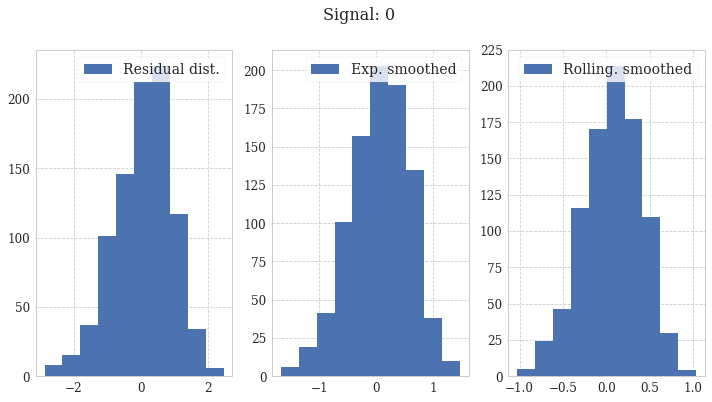

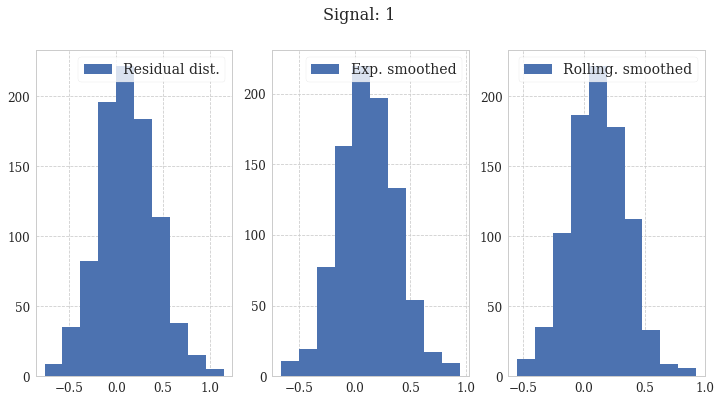

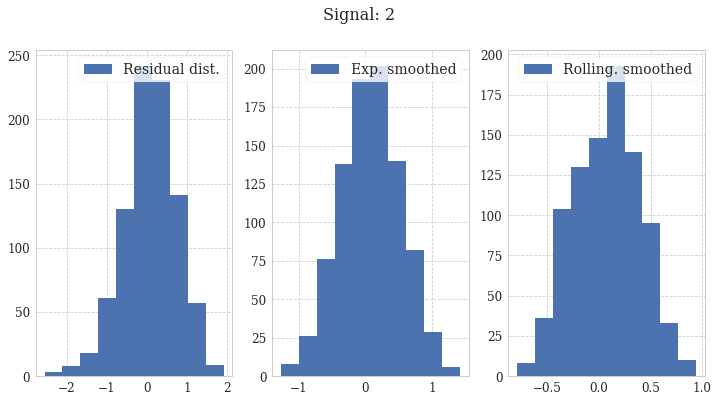

In [5]:
res = [create_residual_distribution(signal = i, plot = True) for i in range(0,3)]

## Probabilistic anomaly detection

In [21]:
# Plot results
def plot_probabilistic_anomalies(anomaly_likelihoods, signal = 0):
    UPPER_ANOMALY_THRESHOLD = 0.99 if not log_likelihood else 0.65

    x = np.linspace(START, END, (END - START))

    positions = [221, 222, 212]
    fig = plt.figure(figsize=(16, 12))
    fig.suptitle('Signal: {}'.format(signal), fontsize=16)
    axs = [fig.add_subplot(i) for i in positions]
    axs[0].plot(x, anomaly_likelihoods[START:END], label="Anomaly likelihood", lw=0, marker='o', ms=3)
    axs[0].axhline(y=UPPER_ANOMALY_THRESHOLD, color='r', linestyle='--')
    axs[0].set_ylim(0, 1.05)

    axs[1].plot(x, y_pred[:,signal][START:END], label = "Actual")
    axs[1].plot(x, y_hat[:,signal][START:END], label = "Predicted")

    axs[2].plot(x, y_pred[:,signal][START:END], label = "Actual")
    axs[2].plot(x, y_hat[:, signal][START:END], label = "Predicted")

    axs[2].fill_between(
        x, 
        -8, 
        5, 
        where = (anomaly_likelihoods[START:END] > UPPER_ANOMALY_THRESHOLD), 
        facecolor='red', 
        interpolate=True,             
        alpha=0.8, 
        linewidth = 20.2
    )

    [ax.legend(frameon=True) for ax in axs]

In [26]:
def tailProbability(x, mu, sigma):
    z = (x - mu) / sigma
    return 1.0 - 0.5 * math.erfc(z / np.sqrt(2))

def calculate_anomaly_score(residuals):
     return pd.DataFrame(
        residuals, 
        columns = ['res']
    ).ewm(alpha = 0.5).mean()['res'].values[-1]
    

def calculate_anomaly_likelihood(
    residuals,
    y, 
    y_hat, 
    mu,
    sigma,
    model = model,
):
    anomaly_score = calculate_anomaly_score(residuals = residuals)
    anomaly_likelihood = tailProbability(anomaly_score, mu, sigma)
    
    if log_likelihood:
        return np.log(1.0000000001 - 2 * abs(0.5 - anomaly_likelihood)) / np.log(1.0 - 0.9999999999)
    else:
        return abs(0.5 - anomaly_likelihood)

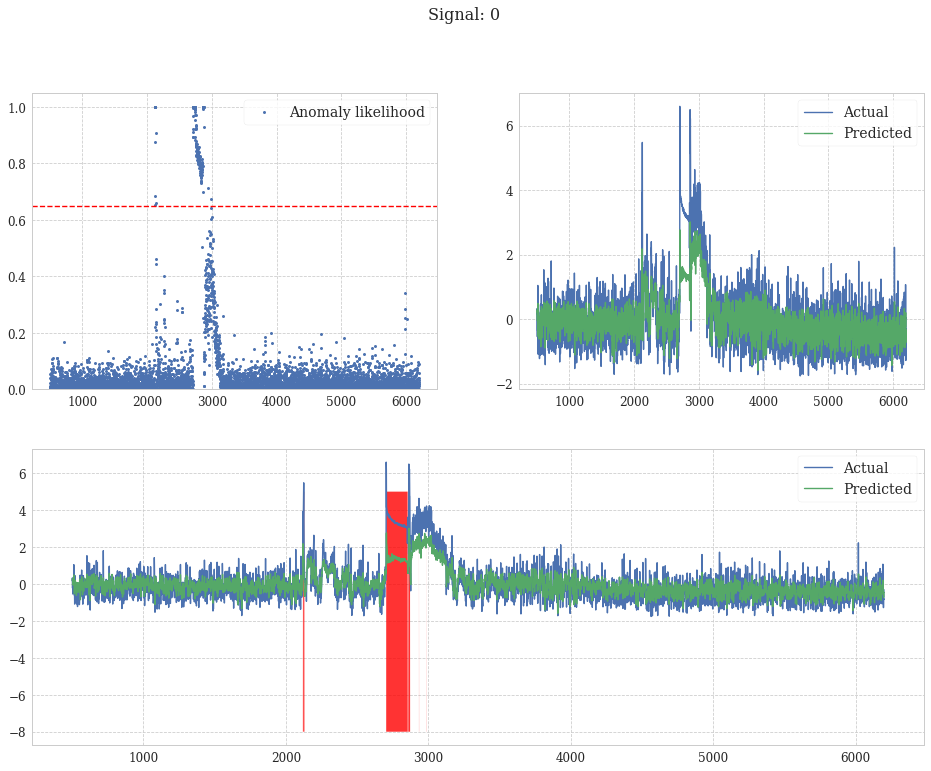

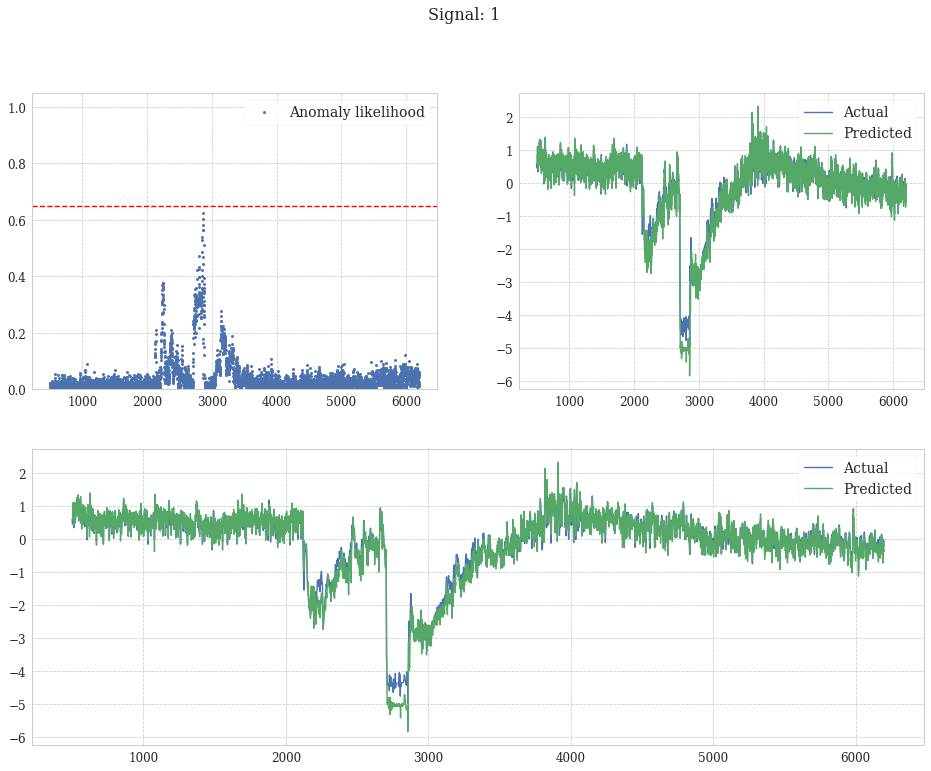

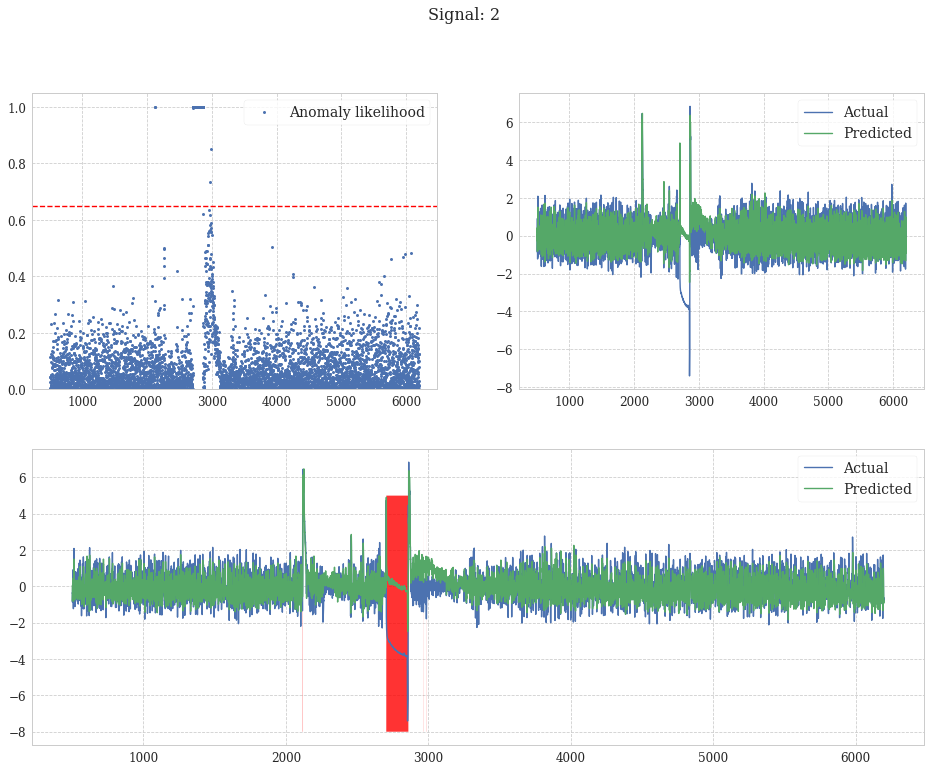

In [28]:
x_pred = x_anomaly
y_pred = y_anomaly

y_hat = model.predict(x_pred)

START = 500
END = len(y_hat) - 1000

log_likelihood = True
NUM_AVERAGED_ANOMALY_SCORES = 6

residuals = np.zeros(len(y_hat))
anomaly_likelihoods = np.zeros(len(y_hat))

def run():
    for signal in range(0, 3):
        res_dist = create_residual_distribution(signal = signal, plot = False)
        (mu, sigma) = getattr(stats, 'norm').fit(res_dist)
        
        for index in range(START, END):    
            residual = y_hat[:,signal][index] - y_pred[:,signal][index]
            residuals[index] = residual
            
            anomaly_likelihoods[index] = calculate_anomaly_likelihood(
                residuals = residuals[(index - NUM_AVERAGED_ANOMALY_SCORES): (index + 1)],
                y = y_pred,
                y_hat = y_hat,
                mu = mu,
                sigma = sigma
            )
        
        plot_probabilistic_anomalies(signal = signal, anomaly_likelihoods = anomaly_likelihoods)
        
run()

## PI Anomaly Detection

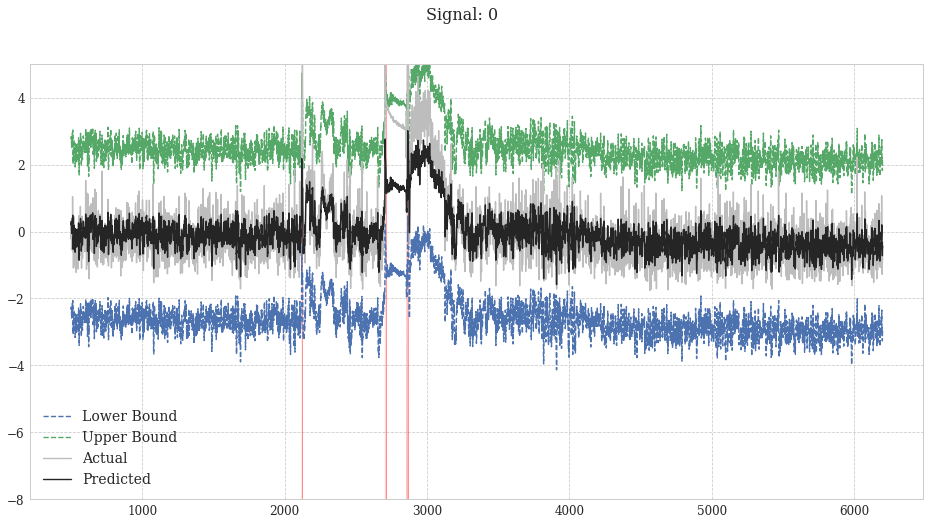

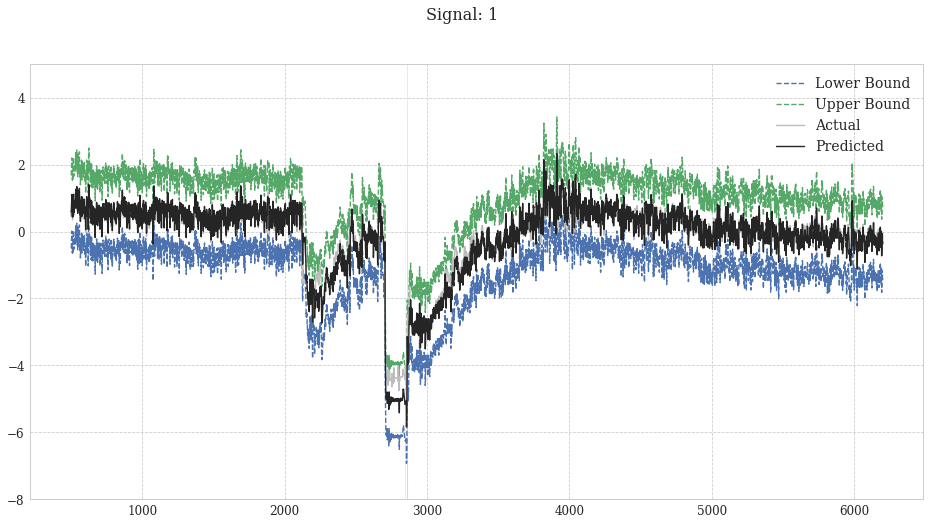

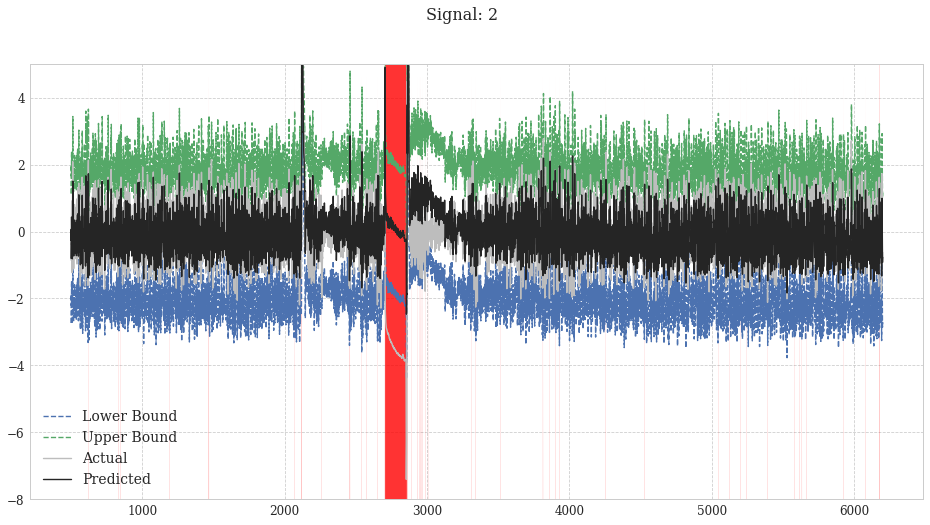

In [30]:
def pi_anomaly_detection():
    for signal in range(0,3):
        stdev = np.sqrt(sum((model.predict(x_train)[:, signal] - y_train[:,signal])**2) / (len(y_train) - 2))

        alpha = 3

        lower_pi = y_hat[:, signal] - alpha * stdev
        upper_pi = y_hat[:, signal] + alpha * stdev

        x = np.linspace(START, END, (END - START))

        positions = [111]
        fig = plt.figure(figsize=(16, 8))
        fig.suptitle('Signal: {}'.format(signal), fontsize=16)
        axs = [fig.add_subplot(i) for i in positions]

        axs[0].plot(x, lower_pi[START:END], linestyle='--', label = "Lower Bound")
        axs[0].plot(x, upper_pi[START:END], linestyle='--', label = "Upper Bound")
        axs[0].plot(x, y_pred[:, signal][START:END], label = "Actual", color="#bdbdbd")
        axs[0].plot(x, y_hat[:, signal][START:END], label = "Predicted", color="#252525")
        axs[0].set_ylim(-8, 5)


        [ax.legend() for ax in axs]

        red_marks = [
            (y_pred[:,signal][i] > upper_pi[i] or y_pred[:,signal][i] < lower_pi[i]) for i in range(START, END)
        ]

        axs[0].fill_between(
            x, 
            -8, 
            5, 
            where = red_marks, 
            facecolor='red', 
            interpolate=True,             
            alpha=0.8, 
            linewidth = 10.2
        )

pi_anomaly_detection()

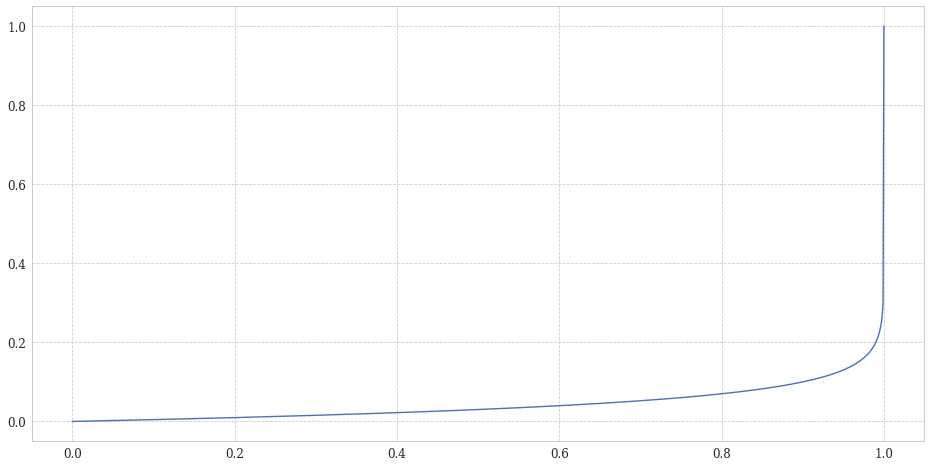

In [16]:
fig1 = plt.figure(figsize=(16,8))
plt.plot(np.linspace(0, 1.0, 1000), np.log(1.0000000001 - np.linspace(0, 1.0, 1000)) / np.log(1.0 - 0.9999999999))
plt.show()